#### 전체적인 데이터 분포와 인사이트를 얻기 위해 간단한 EDA와 LGBM을 활용하여 모델링을 해봤습니다.
#### 도움이 되셨다면 **upvote** 부탁드립니다 ^^
#### 추후 지속적으로 업데이트하겠습니다.
#### 데이터분석, 머신러닝/딥러닝 관련 블로그도 운영하고 있습니다. 관심이 있는 분은 놀러와주세요~   
#### https://bkshin.tistory.com/

# 라이브러리 호출 및 I/O

In [3]:
# 데이터 분석 라이브러리
import numpy as np
import pandas as pd

# 시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# from plotnine import *

# 모델링 라이브러리
# from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

# 기타 라이브러리
import random
import gc
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
sns.set_style("whitegrid")

In [5]:
os.getcwd()

'C:\\Users\\JEONG\\캐글'

In [2]:
train = pd.read_csv('/kaggle/input/kakr-4th-competition/train.csv')
test = pd.read_csv('/kaggle/input/kakr-4th-competition/test.csv')
sample_submission = pd.read_csv('/kaggle/input/kakr-4th-competition/sample_submission.csv')

# 데이터 간단히 둘러보기

- 우선 데이터를 전반적으로 살펴보겠습니다.

In [3]:
train.shape, test.shape, sample_submission.shape

((26049, 16), (6512, 15), (6512, 2))

- train 데이터에는 26,049개의 데이터가 존재하고, test 데이터에는 6,512개의 데이터가 존재합니다.
- train 데이터에는 target variable도 포함하므로 test 데이터보다 feature 개수가 1개 더 많습니다.

In [4]:
train.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K
1,1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,<=50K
2,2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,<=50K
3,3,21,Private,151158,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,<=50K
4,4,24,Private,122234,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,<=50K


id를 제외하고 총 15개의 feature가 있으며 각 feature는 다음과 같은 의미를 가지고 있습니다. (data description에서 제공)

- `age` : 나이
- `workclass` : 고용 형태
- `fnlwgt` : 사람 대표성을 나타내는 가중치 (final weight의 약자)
- `education` : 교육 수준 (최종 학력)
- `education_num` : 교육 수준 수치
- `marital_status`: 결혼 상태
- `occupation` : 업종
- `relationship` : 가족 관계
- `race` : 인종
- `sex` : 성별
- `capital_gain` : 양도 소득
- `capital_loss` : 양도 손실
- `hours_per_week` : 주당 근무 시간
- `native_country` : 국적
- `income` : **수익 (예측해야 하는 값, target variable)**

In [5]:
test.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0,28,Private,67661,Some-college,10,Never-married,Adm-clerical,Other-relative,White,Female,0,0,40,United-States
1,1,40,Self-emp-inc,37869,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
2,2,20,Private,109952,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,25,United-States
3,3,40,Private,114537,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
4,4,37,Private,51264,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,99,France


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26049 entries, 0 to 26048
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              26049 non-null  int64 
 1   age             26049 non-null  int64 
 2   workclass       26049 non-null  object
 3   fnlwgt          26049 non-null  int64 
 4   education       26049 non-null  object
 5   education_num   26049 non-null  int64 
 6   marital_status  26049 non-null  object
 7   occupation      26049 non-null  object
 8   relationship    26049 non-null  object
 9   race            26049 non-null  object
 10  sex             26049 non-null  object
 11  capital_gain    26049 non-null  int64 
 12  capital_loss    26049 non-null  int64 
 13  hours_per_week  26049 non-null  int64 
 14  native_country  26049 non-null  object
 15  income          26049 non-null  object
dtypes: int64(7), object(9)
memory usage: 3.2+ MB


- id를 제외하고 feature의 타입(type)은 int 6개, object 9개입니다. 
- object 타입은 string 타입이라고 보시면 됩니다.

In [7]:
train.describe()

,id,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,26049.000000,26049.000000,2.604900e+04,26049.000000,26049.00000,26049.000000,26049.000000
mean,13024.000000,38.569235,1.903045e+05,10.088372,1087.68970,87.732734,40.443126
std,7519.842917,13.671489,1.059663e+05,2.567610,7388.85469,403.230205,12.361850
min,0.000000,17.000000,1.376900e+04,1.000000,0.00000,0.000000,1.000000
25%,6512.000000,28.000000,1.181080e+05,9.000000,0.00000,0.000000,40.000000
50%,13024.000000,37.000000,1.788660e+05,10.000000,0.00000,0.000000,40.000000
75%,19536.000000,48.000000,2.377350e+05,12.000000,0.00000,0.000000,45.000000
max,26048.000000,90.000000,1.484705e+06,16.000000,99999.00000,4356.000000,99.000000


In [8]:
train.describe(include='O')

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income
count,26049,26049,26049,26049,26049,26049,26049,26049,26049
unique,9,16,7,15,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,18123,8433,11970,3304,10541,22315,17482,23371,19744


In [9]:
print(f'income count: {train["income"].count()}')
print(f'income not null count(pct): {np.round(train["income"].count()/len(train)*100, 2)}%')

income count: 26049
income not null count(pct): 100.0%


## Feature별 Null 값 확인

In [10]:
num_of_null = train.isnull().sum()
percent = (train.isnull().sum() / train.isnull().count() * 100)
pd.concat([num_of_null, percent], axis=1, keys=['# of null', 'Percent']).sort_values(by='Percent', ascending=False)

,# of null,Percent
id,0,0.0
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education_num,0,0.0
marital_status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0


- null값이 하나도 존재하지 않는다는 것을 알 수 있습니다.

In [11]:
num_of_null = test.isnull().sum()
percent = (test.isnull().sum() / test.isnull().count() * 100)
pd.concat([num_of_null, percent], axis=1, keys=['# of null', 'Percent']).sort_values(by='Percent', ascending=False)

,# of null,Percent
id,0,0.0
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education_num,0,0.0
marital_status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0


- test 데이터도 마찬가지로 null값이 하나도 없습니다.

# 모델링 (Modeling)

- ID 칼럼은 분석에 필요한 데이터가 아니므로 train, test 데이터에서 ID 칼럼을 삭제해줍니다.

In [67]:
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

- train feature와 target value를 분리합니다.

In [68]:
y = train['income'] != '<=50K'
X = train.drop(['income'], axis=1)

- 범주형 데이터를 인코딩합니다.

In [69]:
# 라벨 인코더 생성
LE_encoder = OrdinalEncoder(list(X.columns))

# train, test 데이터에 인코딩 적용
X = LE_encoder.fit_transform(X, y)
test = LE_encoder.transform(test)

In [70]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(test.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

In [71]:
model = LGBMClassifier(objective='binary', verbose=400, random_state=91)


for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold: ', fold_n+1)
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    evals = [(X_train, y_train), (X_valid, y_valid)]
    model.fit(X_train, y_train, eval_metric='f1', eval_set=evals, verbose=True)
    
    feature_importances[f'fold_{fold_n + 1}'] = model.feature_importances_
        
    y_preds += model.predict(test).astype(int) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()

Fold:  1
[1]	training's binary_logloss: 0.51029	valid_1's binary_logloss: 0.507521
[2]	training's binary_logloss: 0.477769	valid_1's binary_logloss: 0.475498
[3]	training's binary_logloss: 0.451924	valid_1's binary_logloss: 0.450099
[4]	training's binary_logloss: 0.431056	valid_1's binary_logloss: 0.429931
[5]	training's binary_logloss: 0.413344	valid_1's binary_logloss: 0.412961
[6]	training's binary_logloss: 0.39845	valid_1's binary_logloss: 0.398591
[7]	training's binary_logloss: 0.385568	valid_1's binary_logloss: 0.385989
[8]	training's binary_logloss: 0.374398	valid_1's binary_logloss: 0.375523
[9]	training's binary_logloss: 0.36472	valid_1's binary_logloss: 0.36682
[10]	training's binary_logloss: 0.35611	valid_1's binary_logloss: 0.358814
[11]	training's binary_logloss: 0.348373	valid_1's binary_logloss: 0.351625
[12]	training's binary_logloss: 0.341334	valid_1's binary_logloss: 0.345092
[13]	training's binary_logloss: 0.335245	valid_1's binary_logloss: 0.339384
[14]	training's b

- feature_importance를 활용하여 각 폴드(fold)별로 피쳐 중요도를 살펴보겠습니다. 
- 단, feature_importance는 피쳐 중요도를 파악하기 위한 절대적인 방법이 아닙니다. 그냥 참고만 하시기 바랍니다.

In [72]:
feature_importances

,feature,fold_1,fold_2,fold_3,fold_4,fold_5
0,age,523,530,534,502,523
1,workclass,119,103,113,144,136
2,fnlwgt,446,445,461,420,459
3,education,80,106,118,90,104
4,education_num,224,215,229,226,227
5,marital_status,134,134,133,142,121
6,occupation,295,315,311,348,320
7,relationship,111,130,111,116,130
8,race,40,48,47,55,46
9,sex,69,54,58,55,57


# 제출

In [73]:
sample_submission['prediction'] = y_preds

for ix, row in sample_submission.iterrows():
    if row['prediction'] > 0.5:
        sample_submission.loc[ix, 'prediction'] = 1
    else:
        sample_submission.loc[ix, 'prediction'] = 0

sample_submission = sample_submission.astype({"prediction": int})
sample_submission.to_csv('submission.csv', index=False)

- 마지막으로 submission의 income 분포를 살펴보겠습니다. 

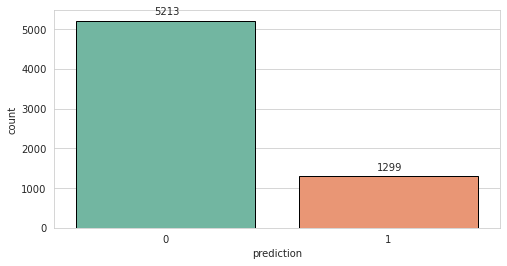

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
col = 'prediction'
value_counts = sample_submission[col].value_counts()
sns.countplot(x=col, data=sample_submission, palette="Set2", edgecolor='black', order = value_counts.index)

for i, v in value_counts.reset_index().iterrows():
    ax.text(i-0.05, v[col]+150 , v[col])

### 업데이트 사항이 있으면 다시 공유하겠습니다! 읽어주셔서 감사합니다.